# Environment Setup:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
import numpy as np
import pandas as pd
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
import seaborn as sns

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten
from sklearn.metrics import confusion_matrix, classification_report

# Using Kaggle API to get the dataset:

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download serenaraju/yawn-eye-dataset-new

In [ ]:
! unzip yawn-eye-dataset-new.zip

# Looking at the data we have:

In [ ]:
batchSize = 32
imageHeight = 256
imageWidth = 256

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset_new/train',
    seed = 123,
    image_size=(imageHeight, imageWidth),
    batch_size = batchSize)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset_new/test',
    seed = 123,
    image_size=(imageHeight, imageWidth),
    batch_size = batchSize)

Found 2467 files belonging to 4 classes.
Found 433 files belonging to 4 classes.


In [ ]:
# Save class names
class_names = train_ds.class_names

In [ ]:
# Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Apply caching and prefetching for training dataset for improved performance
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Apply caching and prefetching for testing dataset for improved performance
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

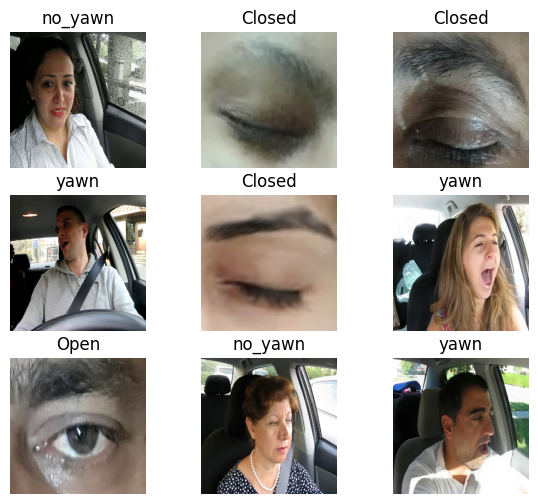

In [ ]:
plt.figure(figsize=(7, 6))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    ax.axis('off')
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(False)

In [ ]:
def preprocess_dataset(dataset):
    # Initialize empty lists to store images and labels
    flat_images = []
    labels = []

    # Iterate over the batches of the dataset
    for images, labels_batch in dataset:
        # Flatten each image
        for image in images.numpy():
            flat_images.append(image.flatten())

        labels.extend(labels_batch.numpy())

    # Convert lists to numpy arrays
    flat_images = np.array(flat_images)
    labels = np.array(labels)

    return flat_images, labels

# Apply the preprocessing to training and testing datasets
X_train, y_train = preprocess_dataset(train_ds)
X_test, y_test = preprocess_dataset(test_ds)

In [ ]:
print("X-train shape: ", X_train.shape)
print("y-train shape: ", y_train.shape)
print("X-test shape: ", X_test.shape)
print("y-test shape: ", y_test.shape)

X-train shape:  (2467, 196608)
y-train shape:  (2467,)
X-test shape:  (433, 196608)
y-test shape:  (433,)


# Random Forest:

In [ ]:
# Create the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the classifier
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy
accuracy_clf = accuracy_score(y_test, y_pred)
print(f"Accuracy using Random Forest: {accuracy_clf * 100:.2f}%")

Accuracy using Random Forest: 89.76%


# KNN (K-Nearest Neighbor):

In [ ]:
# Initializing the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
# Training the model
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
# Make predictions on the test set
y_pred_knn = knn.predict(X_test)

# Calculate the accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy using K-Nearest Neighbor: {accuracy_knn * 100:.2f}%")

Accuracy using K-Nearest Neighbor: 82.22%


# Decision Tree:

In [ ]:
# Creating the Decision Tree classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Training the classifier
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
# Make predictions on the test set
y_pred_dt = dt_clf.predict(X_test)

# Calculate the accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy using Decision Tree: {accuracy_dt * 100:.2f}%")

Accuracy using Decision Tree: 85.91%


# CNN (Convolutional Neural Network):

In [ ]:
# Load the pre-trained VGG16 model without the top layer
model = VGG16(include_top=False, input_shape=(imageHeight, imageWidth, 3), weights='imagenet')
# Freeze the layers of the base_model
for layer in model.layers:
  layer.trainable = False

# Create the model
model = Sequential([
    model,
    # Flatten the output of the VGG16 model
    Flatten(),
    # Connected layer with 256 units
    Dense(256, activation='relu'),
    # Final classification layer
    Dense(len(class_names), activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_18 (Dense)            (None, 256)               8388864   
                                                                 
 dense_19 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 23104580 (88.14 MB)
Trainable params: 8389892 (32.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_ds, validation_data=test_ds, epochs=10)

In [ ]:
# Print the loss and accuracy
train_loss, train_accuracy = history.history['loss'][-1], history.history['accuracy'][-1]
test_loss, test_accuracy = history.history['val_loss'][-1], history.history['val_accuracy'][-1]
print(f'Train Loss: {train_loss :.3f}, Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss :.3f}, Test Accuracy: {test_accuracy * 100:.2f}%')

Train Loss: 0.149, Train Accuracy: 99.55%
Test Loss: 2.851, Test Accuracy: 93.76%


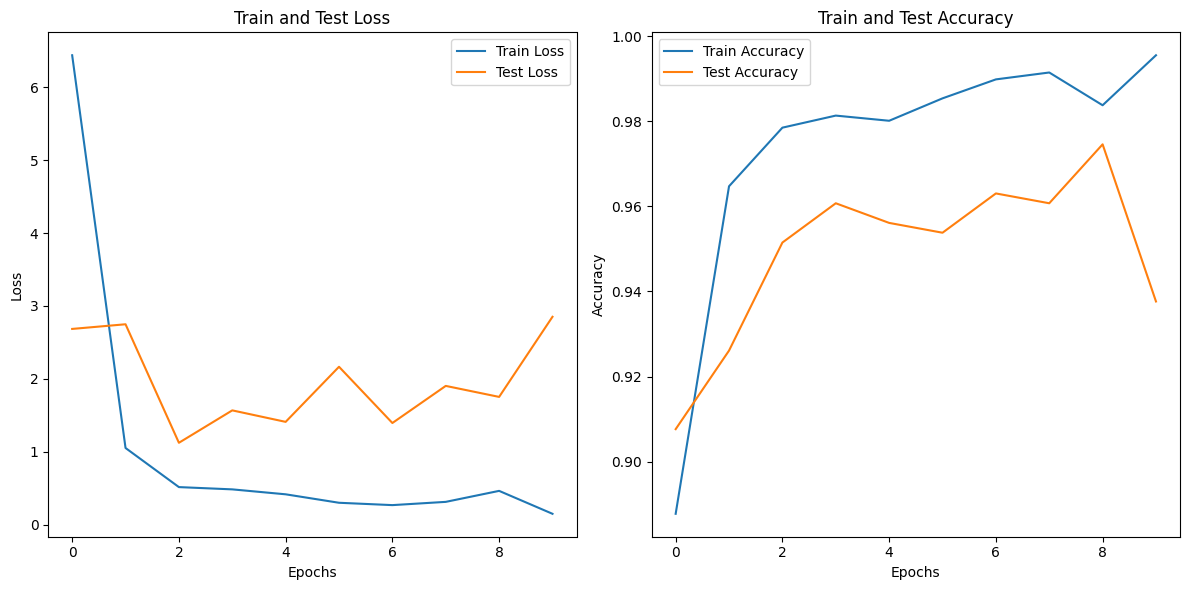

In [ ]:
# Extract accuracy and loss from history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
test_loss = history.history['val_loss']
test_accuracy = history.history['val_accuracy']

epochs_range = range(len(train_loss))
# Plot for loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.title('Train and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy, label='Train Accuracy')
plt.plot(epochs_range, test_accuracy, label='Test Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 29ms/step


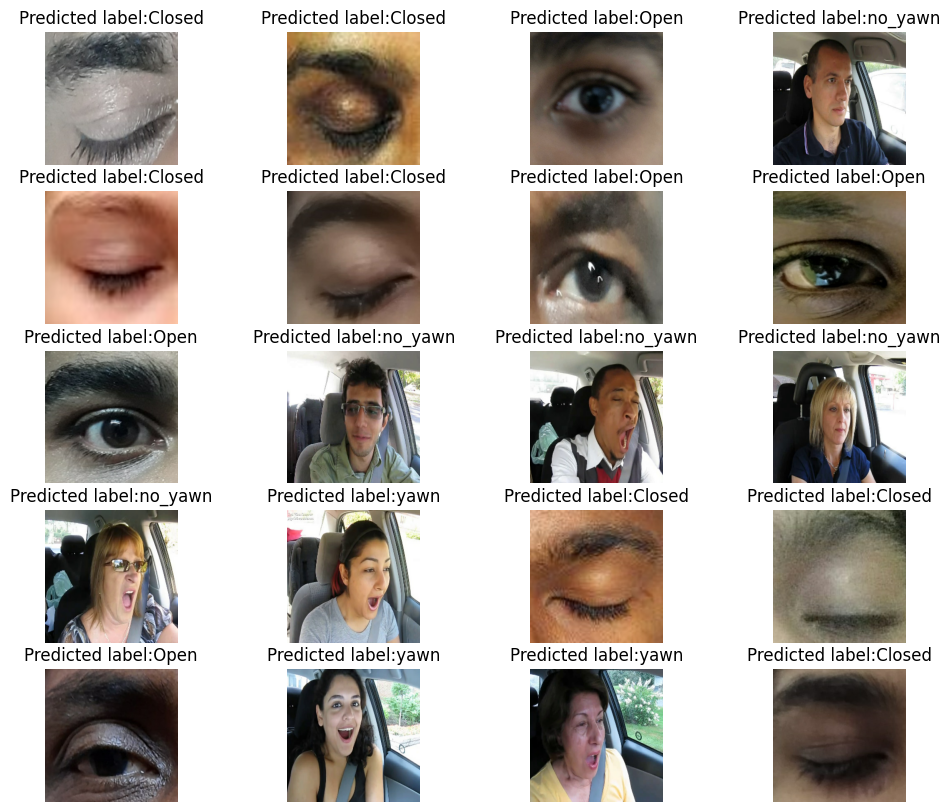

In [ ]:
# Set up the figure size
plt.figure(figsize=(12, 10))
# Loop through the first 2 batches from the test set
for images, labels in test_ds.take(2):
    predictions = model.predict(images)
    predlabel = []
    # Convert model's prediction probabilities to class names
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
    # Visualize the images and their predicted labels
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:'+ predlabel[i])
        plt.axis('off')
        plt.grid(True)

In [ ]:
# Save the Model
model_path = '/content/drive/MyDrive/ColabModel/model.h5'
model.save(model_path)

In [ ]:
# Load the Model
model_path = '/content/drive/MyDrive/ColabModel/model.h5'
loaded_model = load_model(model_path)

# Comparison of Model Accuracies:

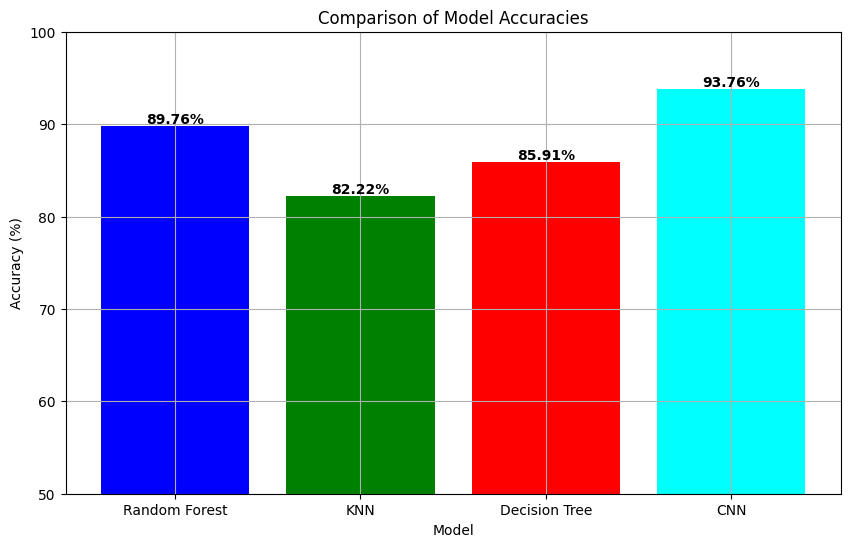

In [ ]:
# From the above data we got:
accuracies = {
    'Random Forest': 89.76,
    'KNN': 82.22,
    'Decision Tree': 85.91,
    'CNN': 93.76
}

# Names of models and their corresponding accuracies
models = list(accuracies.keys())
accuracies = list(accuracies.values())

# Creating the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'red', 'cyan'])
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies')
plt.ylim([50, 100])

# Adding the percentage over each bar
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f"{yval:.2f}%", ha='center', va='bottom', fontweight='bold')

plt.grid(True)
plt.show()

# Testing CNN Model Using External Images:

In [ ]:
!unzip -q /content/TestModel.zip -d /content/TestingModel/

In [ ]:
# Function to preprocess the image
def preprocess_image(image_path):
  # Load and resize the image
  img = image.load_img(image_path, target_size=(256, 256))
  # Convert to numpy array
  img_array = image.img_to_array(img)
  img_array_expanded = np.expand_dims(img_array, axis=0)
  return img_array_expanded

# Function to predict the class of the image
def predict_image(model, image_path, class_names):
  processed_image = preprocess_image(image_path)
  # Make predictions and find the predicted class
  predictions = model.predict(processed_image)
  predicted_class = class_names[np.argmax(predictions)]
  # Find the predicted probability
  predicted_probability = np.max(predictions)
  return predicted_class, predicted_probability

In [ ]:
directory = '/content/TestingModel'

# Looping over each file in the directory
for filename in os.listdir(directory):
    if filename.lower().endswith(('.png', '.jpg')):
        file_path = os.path.join(directory, filename)
        predicted_class, predicted_probability = predict_image(model, file_path, class_names)
        print(f"The file name is: {filename}, the predicted class is: {predicted_class}")
        print()

# Confusion Matrix:

1/1 [==============================] - 0s 33ms/step


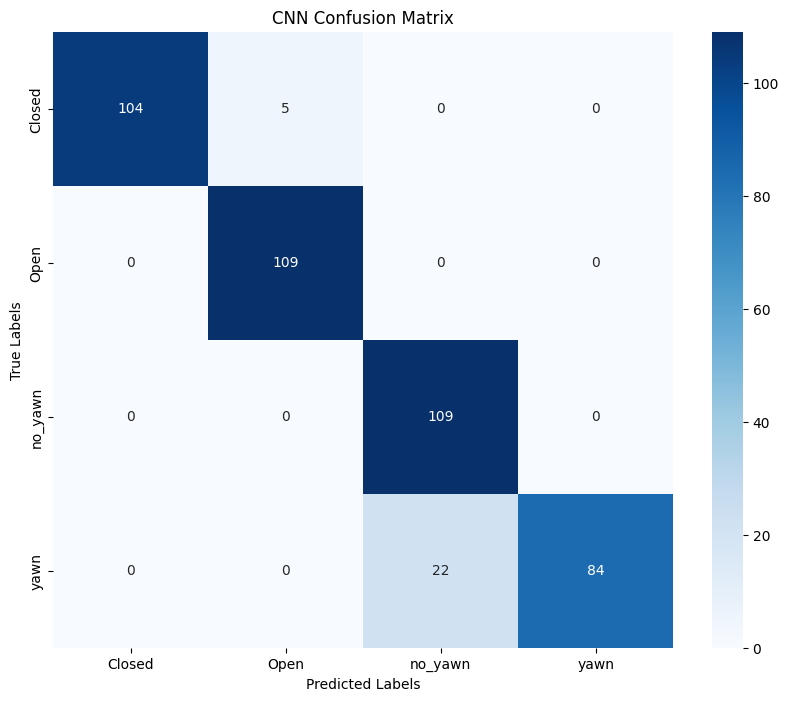

In [ ]:
# Function to convert dataset into batches of images and labels
def get_true_predictions(model, dataset):
    true_labels = []
    predictions = []
    for images, labels in dataset:
        preds = model.predict(images)
        preds = np.argmax(preds, axis=1)
        true_labels.extend(labels.numpy())
        predictions.extend(preds)
    return np.array(true_labels), np.array(predictions)

# Extract true labels and predictions
true_labels, predicted_labels = get_true_predictions(model, test_ds)
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('CNN Confusion Matrix')
plt.show()